# VCs Characteristics exploration

## Data ETL

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
from networkx.algorithms.community import greedy_modularity_communities

# warnings.filterwarnings('ignore')

import sys

sys.path.append('../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

country = "us"
data_dir = f'../../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


In [12]:
tunes = [{
  'min_year': 2005,
  'max_year': 2023,
  'lower_percentile':0.005,
  'upper_percentile':0.3,
  'early_stages': set(['angel', 'pre_seed', 'seed', 'series_a']),
  'late_stages': set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i']),
},
{
  'min_year': 2005,
  'max_year': 2023,
  'lower_percentile':0.3,
  'upper_percentile':0.4,
  'early_stages': set(['angel', 'pre_seed', 'seed', 'series_a']),
  'late_stages': set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i']),  
}]

In [13]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [14]:
investor_counts = vc_investments[vc_investments['investor_country'] == 'United States']['investor_name'].value_counts()
total_investors = len(investor_counts)

tune = tunes[0]
# Count frequency of each investor name
print(tune['lower_percentile'])
print(tune['upper_percentile'])

investor_counts = vc_investments['investor_name'].value_counts()
total_investors = len(investor_counts)
sorted_investors = investor_counts.sort_values(ascending=False)

lower_threshold = int(total_investors * tune['lower_percentile'])
upper_threshold = int(total_investors * tune['upper_percentile'])
mid_range_investors = sorted_investors.iloc[lower_threshold:upper_threshold].index.tolist()

investors_range_mask = vc_investments['investor_name'].isin(mid_range_investors) 

early_stage_mask = vc_investments['investment_type'].isin(tune['early_stages'])
late_stage_mask = vc_investments['investment_type'].isin(tune['late_stages'])

# Create left and right
right_investments = vc_investments[
  (vc_investments['investor_country'] == 'United States') 
  & (early_stage_mask)
  & (investors_range_mask)
  # & (vc_investments['company_ecosystem'] == 'Silicon Valley')
  # & (~category_mask)
]

left_investments = vc_investments[
  (vc_investments['investor_country'] != 'United States') # vc_investments[vc_investments['investment_type'].isin(late_stages)]
  & (late_stage_mask)
]

investments_pairs = create_investment_pairs(left_investments, right_investments, 'left', 'right')
investments_pairs['announced_year'] = investments_pairs[['announced_year_left', 'announced_year_right']].max(axis=1)
investments_pairs['year'] = investments_pairs['announced_year']
investments_pairs['total_funding_usd'] = investments_pairs['total_funding_usd_left']
investments_pairs['company_country'] = investments_pairs['company_country_left']
investments_pairs['category'] = investments_pairs['category_left']

0.005
0.3
Created 12356 investment pairs
Covering 1403 unique investors
Created 12356 investment pairs
Covering 1403 unique investors


## Create bipartite structure

In [15]:
bipartite_graph = create_bipartite_graph(investments_pairs, 'investor_name_left', 'investor_name_right', None, 'left', 'right')

## Network characterizaton

In [16]:
bipartite_sets = get_bipartite_sets(bipartite_graph)

set_0 = bipartite_sets['set_0']
set_1 = bipartite_sets['set_1']

metrics = {}

# Basic metrics
metrics['num_nodes'] = bipartite_graph.number_of_nodes()
metrics['num_edges'] = bipartite_graph.number_of_edges()
metrics['set_0_size'] = len(set_0)
metrics['set_1_size'] = len(set_1)

# Density
metrics['density'] = bipartite.density(bipartite_graph, set_0)

### Degrees

In [17]:
# Degree statistics
degrees_0 = [bipartite_graph.degree(n) for n in set_0]
degrees_1 = [bipartite_graph.degree(n) for n in set_1]

degress = nx.degree(bipartite_graph)

### Closeness

In [18]:
closeness_centrality = nx.closeness_centrality(bipartite_graph)

### Betweenness

In [19]:
betweenness_centrality = nx.betweenness_centrality(bipartite_graph)

### Eigenvector centrality

In [20]:
eigenvector_centrality = nx.eigenvector_centrality(bipartite_graph)

### Distribution

In [30]:
# Calculate metrics for neighbors of each investor node
investor_metrics = {}

for node in bipartite_graph.nodes():
    # if node in set_0:  # Assuming set_0 represents investors
    neighbors = list(bipartite_graph.neighbors(node))
    degrees = [bipartite_graph.degree(neighbor) for neighbor in neighbors]
    closeness = [closeness_centrality[neighbor] for neighbor in neighbors]
    betweenness = [betweenness_centrality[neighbor] for neighbor in neighbors]
    eigenvector = [eigenvector_centrality[neighbor] for neighbor in neighbors]
    
    investor_metrics[node] = {
        'degrees': degrees,
        'closeness_centrality': closeness,
        'betweenness_centrality': betweenness,
        'eigenvector_centrality': eigenvector
    }

# Example: Access metrics for a specific investor
example_investor = list(set_0)[111]
print(f'Metrics for {example_investor}: {investor_metrics[example_investor]}')

Metrics for Prosperity7 Ventures-series_d: {'degrees': [4, 18, 4, 5, 4], 'closeness_centrality': [0.16205603587034928, 0.23480345990088675, 0.16205603587034928, 0.20977945854244714, 0.1879202232194057], 'betweenness_centrality': [2.86585082887307e-06, 0.00454083466989509, 2.86585082887307e-06, 0.0003678176468428174, 7.493385139563323e-05], 'eigenvector_centrality': [0.00010487748446007952, 0.009420746651323768, 0.00010487748446007952, 0.0014277937707416347, 0.00029254687085616705]}


#### Brincadeirinha

In [43]:
G = bipartite_graph
max_communities = 10

cummunities = list(greedy_modularity_communities(G)) # @todo cutoff=10

color_map = {}
for c_idx, community in enumerate(cummunities):
    comm_size = len(community)
    for node in community:
        color_map[node] = c_idx

colors = [color_map[node] for node in G.nodes]



C:\Users\joao.melga\AppData\Local\Temp\ipykernel_55692\3433818270.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


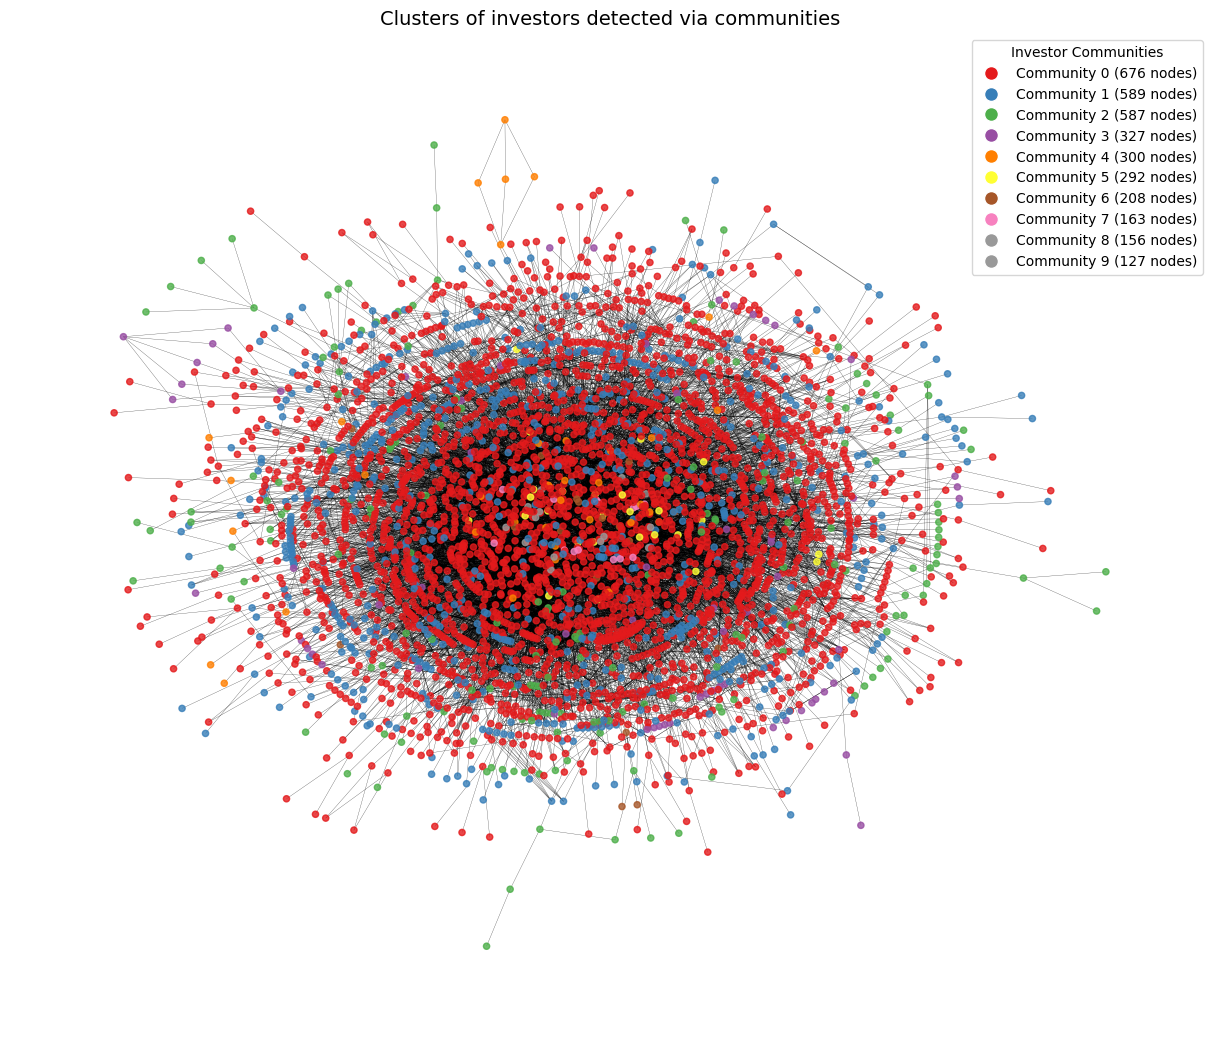

Top 5 investor communities by size:
Community 0: 676 investors
Community 1: 589 investors
Community 2: 587 investors
Community 3: 327 investors
Community 4: 300 investors


In [46]:
plt.figure(figsize=(12, 10))

# Create a spring layout for the graph
# pos = nx.spring_layout(G, seed=42)
pos = nx.kamada_kawai_layout(G)

# Get unique community colors
unique_communities = sorted(set(colors))
color_map = plt.cm.Set1  # Use a color palette with distinct colors

# Draw the graph with improved visibility
nx.draw(G, pos, 
  node_color=colors, 
  node_size=20,  # Increased for better visibility
  width=0.2,     # Slightly thicker edges
  cmap=color_map,
  with_labels=False,
  alpha=0.8)

# Create a legend mapping colors to communities
legend_elements = []
for i, comm_idx in enumerate(unique_communities[:10]):  # Limit to top 10 for readability
    comm_size = colors.count(comm_idx)
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
        label=f'Community {comm_idx} ({comm_size} nodes)',
        markerfacecolor=color_map(comm_idx), 
        markersize=10))

plt.legend(handles=legend_elements, loc='upper right', title='Investor Communities')
plt.title("Clusters of investors detected via communities", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about the largest communities
community_sizes = {}
for comm_idx in unique_communities:
    community_sizes[comm_idx] = colors.count(comm_idx)

top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 investor communities by size:")
for comm_idx, size in top_communities:
    print(f"Community {comm_idx}: {size} investors")

## Nestedness caclulation

In [ ]:
# Initialize storage for community nestedness results
community_nestedness_results = []

# Parameters for null model analysis
n_iterations = 500  # Number of null models to generate
n_iterations_cv = 10000  # Number of curveball iterations
min_community_size = 10  # Minimum nodes required for analysis

print(f"Analyzing nestedness for {len(cummunities)} communities...")
print("=" * 60)

for comm_idx, community in enumerate(cummunities):
    if len(community) < min_community_size:
        print(f"Community {comm_idx}: Skipping (only {len(community)} nodes)")
        continue
    
    try:
        # Extract subgraph for this community
        subgraph = bipartite_graph.subgraph(community)
        
        # Get bipartite sets for this community
        community_set_0 = [node for node in community if node in set_0]
        community_set_1 = [node for node in community if node in set_1]
        
        # Skip if either set is empty
        if len(community_set_0) == 0 or len(community_set_1) == 0:
            print(f"Community {comm_idx}: Skipping (empty bipartite set)")
            continue
        
        print(f"Community {comm_idx}: {len(community_set_0)} left nodes, {len(community_set_1)} right nodes")
        
        # Create adjacency matrix for this community
        left_indices = {node: i for i, node in enumerate(community_set_0)}
        right_indices = {node: j for j, node in enumerate(community_set_1)}
        
        # Initialize adjacency matrix
        community_adjacency_matrix = np.zeros((len(community_set_0), len(community_set_1)))
        
        # Fill matrix with connections within this community
        for left_node in community_set_0:
            for right_node in community_set_1:
                if subgraph.has_edge(left_node, right_node):
                    left_idx = left_indices[left_node]
                    right_idx = right_indices[right_node]
                    community_adjacency_matrix[left_idx, right_idx] = 1
        
        # Calculate observed nestedness
        calculator = NestednessCalculator(community_adjacency_matrix)
        nestedness_score = calculator.nodf(community_adjacency_matrix)
        
        # Calculate basic network metrics
        num_edges = int(community_adjacency_matrix.sum())
        density = community_adjacency_matrix.mean()
        
        print(f"  Observed nestedness (NODF): {nestedness_score:.4f}")
        print(f"  Edges: {num_edges}, Density: {density:.4f}")
        
        # Generate null models if there are enough edges
        if num_edges < 5:
            print(f"  Skipping null model analysis (too few edges: {num_edges})")
            community_nestedness_results.append({
                'community_id': comm_idx,
                'community_size': len(community),
                'left_nodes': len(community_set_0),
                'right_nodes': len(community_set_1),
                'num_edges': num_edges,
                'density': density,
                'observed_nestedness': nestedness_score,
                'null_mean': np.nan,
                'null_std': np.nan,
                'z_score': np.nan,
                'p_value': np.nan,
                'significance': 'insufficient_data'
            })
            continue
        
        # Generate null models using curveball algorithm
        null_nestedness_scores = []
        
        print(f"  Generating {n_iterations} null models...")
        for i in tqdm(range(n_iterations), desc=f"Community {comm_idx}"):
            try:
                # Generate null model matrix by swapping while preserving degrees
                M = community_adjacency_matrix.copy()
                r_hp = find_presences(M)
                RM = curve_ball(M, r_hp, n_iterations_cv)
                
                null_matrix = RM.astype(community_adjacency_matrix.dtype)
                
                # Calculate nestedness of the null model
                calculator_null = NestednessCalculator(null_matrix)
                null_score = calculator_null.nodf(null_matrix)
                null_nestedness_scores.append(null_score)
                
            except Exception as e:
                print(f"    Error in null model iteration {i}: {e}")
                continue
        
        # Calculate statistical significance
        if len(null_nestedness_scores) > 0:
            null_nestedness_scores_np = np.array(null_nestedness_scores)
            mean_null = np.mean(null_nestedness_scores_np)
            std_null = np.std(null_nestedness_scores_np)
            
            if std_null > 0:
                z_score = (nestedness_score - mean_null) / std_null
            else:
                z_score = np.nan
            
            p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)
            significance = 'significant' if p_value < 0.05 else 'not_significant'
            
            print(f"  Null model mean: {mean_null:.4f} ± {std_null:.4f}")
            print(f"  Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
        else:
            mean_null = std_null = z_score = p_value = np.nan
            significance = 'null_model_failed'
            print(f"  Warning: No valid null models generated")
        
        # Store results
        community_nestedness_results.append({
            'community_id': comm_idx,
            'community_size': len(community),
            'left_nodes': len(community_set_0),
            'right_nodes': len(community_set_1),
            'num_edges': num_edges,
            'density': density,
            'observed_nestedness': nestedness_score,
            'null_mean': mean_null,
            'null_std': std_null,
            'z_score': z_score,
            'p_value': p_value,
            'significance': significance,
            'null_scores': null_nestedness_scores if len(null_nestedness_scores) > 0 else []
        })
        
    except Exception as e:
        print(f"Community {comm_idx}: Error - {str(e)}")
        continue

print(f"\nAnalyzed {len(community_nestedness_results)} communities successfully")

Analyzing nestedness for 63 communities...
Community 0: 353 left nodes, 323 right nodes
  Observed nestedness (NODF): 0.0527
  Edges: 1917, Density: 0.0168
  Generating 1000 null models...


Community 0:   5%|▍         | 47/1000 [00:02<00:57, 16.60it/s]



KeyboardInterrupt: 

In [ ]:
# Convert results to DataFrame for analysis
community_nestedness_df = pd.DataFrame(community_nestedness_results)

if len(community_nestedness_df) > 0:
    print("Community Nestedness Analysis Summary:")
    print("=" * 50)
    print(f"Total communities analyzed: {len(community_nestedness_df)}")
    print(f"Significant communities (p < 0.05): {len(community_nestedness_df[community_nestedness_df['significance'] == 'significant'])}")
    
    # Display summary statistics
    print("\nNestedness Statistics:")
    valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    if len(valid_results) > 0:
        print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
        print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
        print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
    
    # Display top communities by nestedness
    print("\nTop 10 Communities by Nestedness:")
    top_communities = community_nestedness_df.nlargest(10, 'observed_nestedness')
    for _, row in top_communities.iterrows():
        print(f"Community {row['community_id']}: NODF={row['observed_nestedness']:.4f}, "
              f"Size={row['community_size']}, Edges={row['num_edges']}, "
              f"P-value={row['p_value']:.4f} ({row['significance']})")
else:
    print("No communities were successfully analyzed")

In [ ]:
# Visualize community nestedness results
if len(community_nestedness_df) > 0:
    valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    
    if len(valid_results) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Community Nestedness Analysis Results', fontsize=16, fontweight='bold')
        
        # Plot 1: Observed vs Null Nestedness
        axes[0, 0].scatter(valid_results['null_mean'], valid_results['observed_nestedness'], 
                          c=valid_results['p_value'], s=valid_results['community_size']*2, 
                          cmap='RdYlBu_r', alpha=0.7)
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
        axes[0, 0].set_xlabel('Null Model Mean Nestedness')
        axes[0, 0].set_ylabel('Observed Nestedness')
        axes[0, 0].set_title('Observed vs Null Nestedness\n(Color: p-value, Size: community size)')
        
        # Plot 2: Distribution of Z-scores
        axes[0, 1].hist(valid_results['z_score'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Z=0')
        axes[0, 1].axvline(1.96, color='orange', linestyle='--', label='Z=1.96 (p=0.05)')
        axes[0, 1].axvline(-1.96, color='orange', linestyle='--')
        axes[0, 1].set_xlabel('Z-score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Nestedness Z-scores')
        axes[0, 1].legend()
        
        # Plot 3: Community size vs Nestedness
        significant_mask = valid_results['significance'] == 'significant'
        axes[1, 0].scatter(valid_results[~significant_mask]['community_size'], 
                          valid_results[~significant_mask]['observed_nestedness'],
                          c='lightcoral', alpha=0.6, label='Not significant')
        axes[1, 0].scatter(valid_results[significant_mask]['community_size'], 
                          valid_results[significant_mask]['observed_nestedness'],
                          c='darkgreen', alpha=0.8, label='Significant')
        axes[1, 0].set_xlabel('Community Size')
        axes[1, 0].set_ylabel('Observed Nestedness')
        axes[1, 0].set_title('Community Size vs Nestedness')
        axes[1, 0].legend()
        
        # Plot 4: P-value distribution
        axes[1, 1].hist(valid_results['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 1].axvline(0.05, color='red', linestyle='--', label='α=0.05')
        axes[1, 1].set_xlabel('P-value')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Distribution of P-values')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Create detailed plots for significant communities
        significant_communities = valid_results[valid_results['significance'] == 'significant'].head(5)
        
        if len(significant_communities) > 0:
            print(f"\nDetailed analysis for top {len(significant_communities)} significant communities:")
            fig, axes = plt.subplots(len(significant_communities), 2, 
                                   figsize=(16, 4*len(significant_communities)))
            if len(significant_communities) == 1:
                axes = axes.reshape(1, -1)
            
            for i, (_, row) in enumerate(significant_communities.iterrows()):
                comm_idx = row['community_id']
                null_scores = row['null_scores']
                
                if len(null_scores) > 0:
                    # Histogram of null model distribution
                    sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
                    axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                                      linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
                    axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                                      linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
                    axes[i, 0].set_title(f'Community {comm_idx} Null Model Analysis\n'
                                         f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.4f}')
                    axes[i, 0].set_xlabel('Nestedness (NODF)')
                    axes[i, 0].set_ylabel('Frequency')
                    axes[i, 0].legend()
                
                # Bar plot of community structure
                axes[i, 1].bar(['Left Nodes', 'Right Nodes'], 
                              [row['left_nodes'], row['right_nodes']], 
                              color=['lightblue', 'lightcoral'])
                axes[i, 1].set_title(f'Community {comm_idx} Structure\n'
                                     f'Total size: {row["community_size"]}, Edges: {row["num_edges"]}')
                axes[i, 1].set_ylabel('Number of Nodes')
            
            plt.tight_layout()
            plt.show()
    else:
        print("No valid results available for visualization")
else:
    print("No data available for visualization")